## 가장 단순한 버전이다. 
1. DEM은 사용하지 않는다.  
2. 그냥 48채널의 이미지 처럼 다룬다. (2D conv 사용)  
3. 별 다른 transform(데이터 전처리)을 하지 않았다. 
4. NDVI없이 B,G,R, NIR만 이용했다.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import tifffile as tiff
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torch.optim as optim
import copy
from utils.utils import train_model, evaluate_model_with_cm, TiffDataset
from models.image_classifier import ResNetLike_48_3, ResNetLike_60_3, ResNetLike_120_3

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 테스트 지역 선별  
train data와 validaiton data가 인접한 패치가 되면 일반화 성능을 올바르게 검증 할 수 없을 것이다.  
따라서 train data에서 사용한 지역과 어느정도는 떯어진 지역의 패치를 validation data로 이용하도록 한다.  
3000*3000의 정사각형 지역(이미지)를 300*300 크기의 지역 100개로 나눈 후 이중 임의로 약 20개를 뽑아서 validation data로 이용했다.  
아래는 validation data의 위치를 시각화 하는 코드이다.(빨간색이 테스트 지역임)

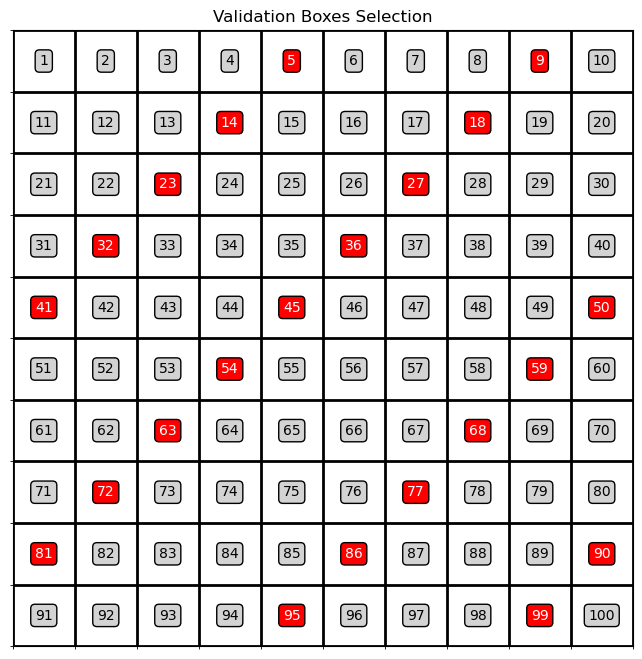

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 10x10 격자에서 1부터 100까지 박스 번호 생성 (책 읽는 순서로)
grid_size = 10
box_numbers = np.arange(1, 101).reshape((grid_size, grid_size), order='C')[::-1]

# 테스트 필터 정의
test_filter = lambda box_number: (box_number % 9 == 0 or box_number % 9 == 5)

# 테스트할 박스 선택
test_boxes = np.vectorize(test_filter)(box_numbers)

# 시각화
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks(np.arange(grid_size + 1) - 0.5, minor=True)
ax.set_yticks(np.arange(grid_size + 1) - 0.5, minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=2)

# 박스에 숫자 표시 및 색상 적용
for i in range(grid_size):
    for j in range(grid_size):
        box_number = box_numbers[i, j]
        ax.text(j, i, str(box_number), ha='center', va='center', fontsize=10, 
                color='white' if test_boxes[i, j] else 'black', 
                bbox=dict(facecolor='red' if test_boxes[i, j] else 'lightgray', 
                          edgecolor='black', boxstyle='round,pad=0.3'))

# 축을 숨김
ax.set_xticks([])
ax.set_yticks([])

plt.title("Validation Boxes Selection")
plt.show()


### 모델 훈련

In [ ]:
# 이미지 전처리 (Naive)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.float()),  # uint16 → float 변환
])

In [ ]:
train_dataset = TiffDataset(
    large_tif_dir = r"C:\Users\taebin\Desktop\my_study\capstone_design\data3\원천 데이터\naive",
    file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
    label_file = r"C:\Users\taebin\Desktop\my_study\capstone_design\data3\라벨링 데이터\label_mapping_sampled.csv",
    box_filter_fn = lambda box_number: not test_filter(box_number),
    transform=transform
)

val_dataset = TiffDataset(
    large_tif_dir = r"C:\Users\taebin\Desktop\my_study\capstone_design\data3\원천 데이터\naive",
    file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
    label_file = r"C:\Users\taebin\Desktop\my_study\capstone_design\data3\라벨링 데이터\label_mapping_sampled.csv",
    box_filter_fn = test_filter,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [ ]:
model = ResNetLike_48_3(num_classes=6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_model_state, train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=100
)
torch.save(best_model_state, "./checkpoints/image_classification/ResNetLike_48_3_100.pth")
model.load_state_dict(best_model_state)

print("\ntrain data")
evaluate_model_with_cm(model, train_loader, num_classes=6)
print("\nvalidation data")
evaluate_model_with_cm(model, val_loader, num_classes=6)

## ndvi도 추가된 데이터 사용

In [111]:
train_dataset = TiffDataset(
    large_tif_dir = r"C:\Users\taebin\Desktop\my_study\capstone_design\data3\원천 데이터\with_ndvi",
    file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
    label_file = r"C:\Users\taebin\Desktop\my_study\capstone_design\data3\라벨링 데이터\label_mapping_sampled.csv",
    box_filter_fn = lambda box_number: not test_filter(box_number),
    transform=transform
)

val_dataset = TiffDataset(
    large_tif_dir = r"C:\Users\taebin\Desktop\my_study\capstone_design\data3\원천 데이터\with_ndvi",
    file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
    label_file = r"C:\Users\taebin\Desktop\my_study\capstone_design\data3\라벨링 데이터\label_mapping_sampled.csv",
    box_filter_fn = test_filter,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [ ]:
model = ResNetLike_60_3(num_classes=6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_model_state, train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=100
)
torch.save(best_model_state, "./checkpoints/image_classification/ResNetLike_60_3_100.pth")
model.load_state_dict(best_model_state)

print("\ntrain data")
evaluate_model_with_cm(model, train_loader, num_classes=6)
print("\nvalidation data")
evaluate_model_with_cm(model, val_loader, num_classes=6)

## Sentinel_2 데이터도 추가하여 사용

In [9]:
train_dataset = TiffDataset(
    large_tif_dir = r"C:\Users\taebin\Desktop\my_study\capstone_design\data3\원천 데이터\with_ndvi_s2",
    file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
    label_file = r"C:\Users\taebin\Desktop\my_study\capstone_design\data3\라벨링 데이터\label_mapping_sampled.csv",
    box_filter_fn = lambda box_number: not test_filter(box_number),
    transform=transform
)

val_dataset = TiffDataset(
    large_tif_dir = r"C:\Users\taebin\Desktop\my_study\capstone_design\data3\원천 데이터\with_ndvi_s2",
    file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
    label_file = r"C:\Users\taebin\Desktop\my_study\capstone_design\data3\라벨링 데이터\label_mapping_sampled.csv",
    box_filter_fn = test_filter,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [ ]:
model = ResNetLike_120_3(num_classes=6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_model_state, train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=100
)
torch.save(best_model_state, "./checkpoints/image_classification/ResNetLike_120_3_100.pth")
model.load_state_dict(best_model_state)

print("\ntrain data")
evaluate_model_with_cm(model, train_loader, num_classes=6)
print("\nvalidation data")
evaluate_model_with_cm(model, val_loader, num_classes=6)

100%|██████████| 3733/3733 [16:12<00:00,  3.84it/s]


Epoch [1/100], Train Loss: 0.5985, Train Accuracy: 77.76%, Val Loss: 0.5478, Val Accuracy: 81.69%


100%|██████████| 3733/3733 [16:12<00:00,  3.84it/s]


Epoch [2/100], Train Loss: 0.4507, Train Accuracy: 83.69%, Val Loss: 0.4827, Val Accuracy: 83.16%


100%|██████████| 3733/3733 [16:14<00:00,  3.83it/s]


Epoch [3/100], Train Loss: 0.4006, Train Accuracy: 85.55%, Val Loss: 0.5006, Val Accuracy: 84.81%


100%|██████████| 3733/3733 [16:13<00:00,  3.83it/s]


Epoch [4/100], Train Loss: 0.3659, Train Accuracy: 86.71%, Val Loss: 0.5315, Val Accuracy: 83.68%


100%|██████████| 3733/3733 [16:11<00:00,  3.84it/s]


Epoch [5/100], Train Loss: 0.3403, Train Accuracy: 87.49%, Val Loss: 0.5209, Val Accuracy: 84.28%


100%|██████████| 3733/3733 [16:13<00:00,  3.83it/s]


Epoch [6/100], Train Loss: 0.3154, Train Accuracy: 88.31%, Val Loss: 0.6443, Val Accuracy: 80.60%


100%|██████████| 3733/3733 [16:16<00:00,  3.82it/s]


Epoch [7/100], Train Loss: 0.2936, Train Accuracy: 89.25%, Val Loss: 0.4831, Val Accuracy: 84.48%


100%|██████████| 3733/3733 [16:13<00:00,  3.83it/s]


Epoch [8/100], Train Loss: 0.2759, Train Accuracy: 89.90%, Val Loss: 0.5114, Val Accuracy: 84.92%


100%|██████████| 3733/3733 [16:13<00:00,  3.83it/s]


Epoch [9/100], Train Loss: 0.2575, Train Accuracy: 90.55%, Val Loss: 0.7257, Val Accuracy: 80.48%


100%|██████████| 3733/3733 [16:12<00:00,  3.84it/s]


Epoch [10/100], Train Loss: 0.2436, Train Accuracy: 90.98%, Val Loss: 0.6072, Val Accuracy: 84.21%


100%|██████████| 3733/3733 [16:12<00:00,  3.84it/s]


Epoch [11/100], Train Loss: 0.2284, Train Accuracy: 91.55%, Val Loss: 0.5714, Val Accuracy: 84.47%


100%|██████████| 3733/3733 [16:11<00:00,  3.84it/s]


Epoch [12/100], Train Loss: 0.2148, Train Accuracy: 92.14%, Val Loss: 0.6169, Val Accuracy: 81.55%
Early stopping triggered. Training stopped.
